In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ssl
import geopandas as gpd
ssl._create_default_https_context = ssl._create_unverified_context
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import webbrowser
from pyogrio import read_dataframe

In [3]:
# In de provincie Utrecht voor de 26 gemeentes, op buurt niveau een analyse van vergelijkbare variabele

#### Opzetten van scope: welke gemeente en locaties wil je analyseren

In [4]:
provincie_utrecht_gemeente =[
    'Amersfoort',
    'Baarn',
    'Bunnik',
    'Bunschoten',
    'De Bilt',
    'De Ronde Venen',
    'Eemnes',
    'Houten',
    'Leusden',
    'Lopik',
    'Montfoort',
    'Nieuwegein',
    'Oudewater',
    'Renswoude',
    'Rhenen',
    'Soest',
    'Stichtse Vecht',
    'Utrecht',
    'Utrechtse Heuvelrug',
    'Veenendaal',
    'Vijfheerenlanden',
    'Wijk bij Duurstede',
    'Woerden',
    'Woudenberg',
    'IJsselstein',
    'Zeist']

gemeente_selectie = provincie_utrecht_gemeente

In [5]:
# easy settings
clean_up = False
round_nr =2

In [6]:
def clean_up_columns(X, clean_up_columns):
    for column in clean_up_columns:
        X[column] = X[column].replace(",", ".", regex=True)  
        X[column] = X[column].replace('       .', '.', regex=True)    
        X.loc[X[column] == '.', column] = 0
        X[column] = round(X[column].astype(float), round_nr)

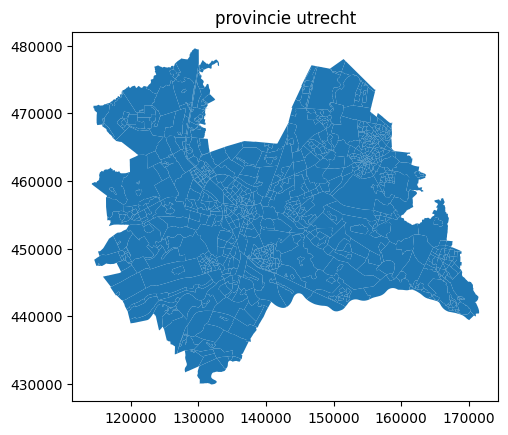

In [7]:
##### CREATE MAP #####
file_path = '../data/buurt_2020_v3.shp'
buurten_map = read_dataframe(file_path) #lot faster
# buurten_map = gpd.read_file(file_path)

gem_map = buurten_map.loc[buurten_map['GM_NAAM'].isin(gemeente_selectie)]

if clean_up:
    drop_buurten_houten = ['Buitengebied Houten West',
        'Buitengebied Houten Oost', "Dorp 't Goy", "'t Goyse Dorp",
        "Buitengebied 't Goy", "'t Waal", 'Tull',
        "Buitengebied Tull en 't Waal", 'Dorp Schalkwijk West',
        'Dorp Schalkwijk Oost', 'Buitengebied Schalkwijk West',
        'Buitengebied Schalkwijk Oost','Bruggen', 'Bogen', 'De Poel',
        'Schepen', 'Boten', 'Honen', 'Kaden', 'Vesten', 'De Staart',
        'Hof van Wulven', 'Rondweg Noord-Oost', 'Rondweg Noord-West',
        'Rondweg Zuid-Oost', 'Rondweg Zuid-West'] 

    drop_buurten_utrecht = [
        'Bedrijventerrein Lageweide',
        'Haarzuilens en omgeving',
        'Bedrijventerrein en omgeving',
        'Utrecht Science Park',
                'Bedrijvengebied Strijkviertel', 
                'Bedrijvengebied Papendorp',
                'Rijnenburg',
                'Poldergebied Overvecht' ,
                ]

    gem_map = gem_map.loc[~gem_map['BU_NAAM'].isin(drop_buurten_houten)]
    gem_map = gem_map.loc[~gem_map['BU_NAAM'].isin(drop_buurten_utrecht)]

gem_map.plot()
plt.title('provincie utrecht')
plt.show()
# plt.savefig('plots/gem_map.png')

#### Identifier opstellen

In [8]:
# identifier voor elke buurt op basis van cbs wijk en buurt data
totale_dataset_kerncijfers = pd.read_excel('../data/kwb-2022.xlsx')
gemeente_kerncijfers = totale_dataset_kerncijfers.loc[totale_dataset_kerncijfers['gm_naam'].isin(gemeente_selectie)]
kerncijfers = gemeente_kerncijfers.loc[gemeente_kerncijfers['recs'] == 'Buurt']
buurt_id = kerncijfers[['gwb_code_10', 'regio']]
buurt_id.head()

,gwb_code_10,regio
4205,BU03070100,Hof
4206,BU03070101,Nieuwstraat e.o.
4207,BU03070102,Mooierstraat e.o.
4208,BU03070103,Lieve Vrouwekerkhof
4209,BU03070104,Coninckstraat e.o.


#### Basis features per buurt 

In [9]:
# select kerncijfers die relevant zijn op basis van eda notebook
kerncijfers = kerncijfers.drop(['gwb_code_8','recs','gwb_code','ind_wbi'], axis=1) #'gm_naam',regio
relevante_kerncijfers_sel = ['gwb_code_10','gm_naam','regio', 'a_inw', 'a_25_44',  'a_hh_m_k', 'g_hhgro', 'a_woning', 'g_woz', 'p_mgezw', 'p_bewndw', 'p_koopw', 'p_bjo2k']
kerncijfers_sel = kerncijfers[relevante_kerncijfers_sel]
kerncijfers_sel['a_25_44'] = round(((kerncijfers_sel['a_25_44'] / kerncijfers_sel['a_inw']) * 100), round_nr)
kerncijfers_sel['a_hh_m_k'] = round(((kerncijfers_sel['a_hh_m_k'] / kerncijfers_sel['a_inw']) * 100), round_nr)
clean_up_columns(kerncijfers_sel, ['g_hhgro', 'g_woz', 'p_mgezw', 'p_bewndw', 'p_koopw', 'p_bjo2k'])

/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_87349/2268564481.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kerncijfers_sel['a_25_44'] = round(((kerncijfers_sel['a_25_44'] / kerncijfers_sel['a_inw']) * 100), round_nr)
/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_87349/2268564481.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kerncijfers_sel['a_hh_m_k'] = round(((kerncijfers_sel['a_hh_m_k'] / kerncijfers_sel['a_inw']) * 100), round_nr)
/var/folders/1r/tdmn3kx53dxffhrmfb

In [10]:
kerncijfers_sel.head()

,gwb_code_10,gm_naam,regio,a_inw,a_25_44,a_hh_m_k,g_hhgro,a_woning,g_woz,p_mgezw,p_bewndw,p_koopw,p_bjo2k
4205,BU03070100,Amersfoort,Hof,710,36.62,5.63,1.4,396,335.0,69.0,91.0,26.0,2.0
4206,BU03070101,Amersfoort,Nieuwstraat e.o.,460,32.61,8.70,1.6,259,420.0,61.0,93.0,41.0,11.0
4207,BU03070102,Amersfoort,Mooierstraat e.o.,165,24.24,12.12,1.7,100,440.0,72.0,89.0,45.0,0.0
4208,BU03070103,Amersfoort,Lieve Vrouwekerkhof,465,32.26,8.60,1.6,298,341.0,77.0,94.0,33.0,1.0
4209,BU03070104,Amersfoort,Coninckstraat e.o.,1255,33.86,8.76,1.6,772,308.0,48.0,95.0,29.0,5.0


#### Extra features per buurt 

In [11]:
# nabijheid tot andere faciliteiten in de buurt
nabijheid1 = pd.read_csv('../data/85231NED_UntypedDataSet_06012023_093617.csv' , delimiter=';')
nabijheid2 = pd.read_csv('../data/85231NED_UntypedDataSet_06012023_093718.csv' , delimiter=';')

nabijheid = pd.concat([nabijheid1, nabijheid2])
nabijheid = nabijheid.loc[nabijheid['SoortRegio_2'] == 'Buurt     ']
nabijheid = nabijheid.drop(['ID', 'WijkenEnBuurten', 'Gemeentenaam_1', 'SoortRegio_2','IndelingswijzigingWijkenEnBuurten_4'], axis=1)
nabijheid.head()

,Codering_3,AfstandTotHuisartsenpraktijk_5,Binnen1Km_6,Binnen3Km_7,Binnen5Km_8,AfstandTotHuisartsenpost_9,AfstandTotApotheek_10,AfstandTotZiekenhuis_11,Binnen5Km_12,Binnen10Km_13,...,Binnen5Km_105,Binnen10Km_106,Binnen20Km_107,AfstandTotSauna_108,AfstandTotZonnebank_109,AfstandTotAttractie_110,Binnen10Km_111,Binnen20Km_112,Binnen50Km_113,AfstandTotBrandweerkazerne_114
2,BU03070100,0.8,2.1,14.0,20.0,.,0.9,2.3,2.0,2.9,...,2.0,2.0,5.0,0.5,0.7,3.3,2.0,5.0,52.2,1.1
3,BU03070101,0.5,2.2,14.0,20.3,.,0.9,2.6,2.0,3.0,...,2.0,2.0,5.0,0.5,0.5,3.5,2.0,5.0,52.3,1.4
4,BU03070102,0.5,2.0,14.0,20.7,.,0.7,2.6,2.0,3.0,...,2.0,2.0,5.0,0.6,0.3,3.3,2.0,5.0,52.1,1.4
5,BU03070103,0.7,2.0,14.0,17.9,.,0.7,2.4,2.0,2.2,...,2.0,2.0,5.0,0.8,0.5,3.1,2.0,5.0,52.0,1.1
6,BU03070104,0.7,2.4,14.0,19.9,.,0.7,2.6,2.0,3.0,...,2.0,2.0,5.0,0.3,0.7,3.6,2.0,5.0,52.2,1.3


In [12]:
relevante_nabijheid_sel = [ 'Codering_3',
                            'AfstandTotZiekenhuis_11',
                            'AfstandTotGroteSupermarkt_24', 
                            'AfstandTotCafeED_36',
                            'AfstandTotKinderdagverblijf_52', 
                            'AfstandTotBuitenschoolseOpvang_56', 
                            'AfstandTotOpenbaarGroenTotaal_76', 
                            'AfstandTotParkOfPlantsoen_77', 
                            'AfstandTotBos_79',
                            'AfstandTotOpritHoofdverkeersweg_89',
                            'AfstandTotTreinstationsTotaal_90', 
                            'AfstandTotSemiOpenbaarGroenTotaal_83']

In [13]:
nabijheid_sel = nabijheid[relevante_nabijheid_sel]
clean_cols = [
 'AfstandTotZiekenhuis_11',
 'AfstandTotGroteSupermarkt_24',
 'AfstandTotCafeED_36',
 'AfstandTotKinderdagverblijf_52',
 'AfstandTotBuitenschoolseOpvang_56',
 'AfstandTotOpenbaarGroenTotaal_76',
 'AfstandTotParkOfPlantsoen_77',
 'AfstandTotBos_79',
 'AfstandTotOpritHoofdverkeersweg_89',
 'AfstandTotTreinstationsTotaal_90',
 'AfstandTotSemiOpenbaarGroenTotaal_83']
clean_up_columns(nabijheid_sel, clean_cols)


/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_87349/3971359954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].replace(",", ".", regex=True)
/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_87349/3971359954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].replace('       .', '.', regex=True)
/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_87349/3971359954.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [14]:
# toevoegen van de leefbarometer score
leefbarometer = pd.read_csv('../data/Leefbaarometer 3.0 - meting 2020 - scores buurt.csv')  
leefbarometer = leefbarometer.loc[leefbarometer['jaar'] == 2020]
leefbarometer = leefbarometer.drop(['versie', 'jaar', 'bu_naam', 'afw', 'won'], axis=1)
for col in leefbarometer.columns:
    if col != 'bu_code':
        leefbarometer[col] = round(leefbarometer[col], round_nr)
        
leefbarometer.head()

,bu_code,lbm,fys,onv,soc,vrz
6,BU00030000,4.12,0.02,0.02,0.02,-0.07
13,BU00030001,4.10,0.01,0.04,0.04,-0.12
20,BU00030002,4.01,0.02,-0.01,-0.00,-0.11
27,BU00030007,4.23,-0.00,0.10,0.11,-0.16
34,BU00030008,4.20,-0.08,0.10,0.13,-0.20


In [15]:
# energieverbruik per buurt
energieverbruik = pd.read_csv('../data/Energieverbruik_woningen__wijkbuurt_2021_06012023_100550.csv', delimiter=';') ## per buurt in utrecht selectie opendata
energieverbruik = buurt_id.merge(energieverbruik, left_on='regio', right_on='Wijken en buurten', how ='left')
energieverbruik = energieverbruik.loc[energieverbruik['gwb_code_10'].notna()]
energieverbruik = energieverbruik.loc[energieverbruik['Gemiddeld aardgasverbruik (m3)'].notna()]
energieverbruik = energieverbruik.drop(['Woningkenmerken', 'Wijken en buurten', 'regio', 'Indelingswijziging wijken en buurten (code)', 'Stadsverwarming (%)'], axis=1)
clean_up_columns(energieverbruik, ['Gemiddeld aardgasverbruik (m3)', 'Gemiddeld elektriciteitsverbruik (kWh)'])
energieverbruik = energieverbruik.groupby("gwb_code_10").agg({
    'Gemiddeld aardgasverbruik (m3)' : 'mean', 
    'Gemiddeld elektriciteitsverbruik (kWh)' : 'mean'}).reset_index()

energieverbruik.head()

,gwb_code_10,Gemiddeld aardgasverbruik (m3),Gemiddeld elektriciteitsverbruik (kWh)
0,BU03070100,1310.0,2430.0
1,BU03070101,1280.0,2600.0
2,BU03070102,1350.0,2770.0
3,BU03070103,1170.0,2290.0
4,BU03070104,1150.0,2300.0


In [16]:
# social economische score dataset
social_economische_score = pd.read_csv('../data/SES_WOA_scores_per_wijk_en_buurt_06012023_102134.csv', delimiter=';') ## per buurt (ook gemeente en wijk regels) in utrecht selectie opendata
social_economische_score = social_economische_score.merge(buurt_id, left_on='Wijken en buurten', right_on='regio', how ='left')
social_economische_score = social_economische_score.drop(['Perioden', 'Wijken en buurten', 'regio', 'Spreiding/Spreiding totaal/Waarde (Getal)','Particuliere huishoudens (Aantal)' ], axis=1)
social_economische_score = social_economische_score.loc[social_economische_score['gwb_code_10'].notna()]
social_economische_score['SES-WOA/Totaalscore/Gemiddelde score (Getal)'] = social_economische_score['SES-WOA/Totaalscore/Gemiddelde score (Getal)'].replace('       .', '.', regex=True) 
social_economische_score.loc[social_economische_score['SES-WOA/Totaalscore/Gemiddelde score (Getal)'] == '.', 'SES-WOA/Totaalscore/Gemiddelde score (Getal)'] = 0
social_economische_score['SES-WOA/Totaalscore/Gemiddelde score (Getal)'] = round(social_economische_score['SES-WOA/Totaalscore/Gemiddelde score (Getal)'].astype(float), round_nr)
social_economische_score = social_economische_score.loc[social_economische_score['SES-WOA/Totaalscore/Gemiddelde score (Getal)'].notna()]
social_economische_score = social_economische_score.groupby("gwb_code_10").agg({
    'SES-WOA/Totaalscore/Gemiddelde score (Getal)' : 'mean'}).reset_index()
social_economische_score.head()

,gwb_code_10,SES-WOA/Totaalscore/Gemiddelde score (Getal)
0,BU03070100,-0.12
1,BU03070101,0.09
2,BU03070102,0.00
3,BU03070103,-0.04
4,BU03070104,-0.12


In [17]:
# geluidsoverlast
geluid_per_buurt = pd.read_csv('../data/50066NED_UntypedDataSet_06012023_103445.csv', delimiter=';') ## https://statline.rivm.nl/portal.html?_la=nl&_catalog=RIVM&tableId=50066NED&_theme=96
geluid_per_buurt = geluid_per_buurt.loc[geluid_per_buurt['SoortRegio_2'] == 'Buurt   ']
unieke_buurt_ids = buurt_id['gwb_code_10'].unique().tolist()
geluid_per_buurt = geluid_per_buurt.loc[geluid_per_buurt['Codering_3'].isin(unieke_buurt_ids)]
geluid_per_buurt = geluid_per_buurt.drop(['ID', 'Geluidblootstelling', 'WijkenEnBuurten', 'Gemeentenaam_1','SoortRegio_2','Bevolking_6' ], axis=1)
clean_up_columns(geluid_per_buurt, ['GeluidVanTreinverkeer_4', 'GeluidVanWegverkeer_5'])

geluid_per_buurt = geluid_per_buurt.groupby("Codering_3").agg({
    'GeluidVanTreinverkeer_4' : 'mean',
    'GeluidVanWegverkeer_5': 'mean'}).reset_index()
social_economische_score.head()
geluid_per_buurt.head()

,Codering_3,GeluidVanTreinverkeer_4,GeluidVanWegverkeer_5
0,BU03070100,20.00,31.65
1,BU03070101,20.00,27.01
2,BU03070102,20.00,24.79
3,BU03070103,20.00,30.61
4,BU03070104,20.45,28.56


In [18]:
# MERGING DATASETS PER BUURT

buurten = pd.DataFrame(buurt_id['gwb_code_10'])
buurten = buurten.merge(kerncijfers_sel, left_on='gwb_code_10',right_on='gwb_code_10', how='left')
buurten = buurten.merge(nabijheid_sel, left_on='gwb_code_10',right_on='Codering_3', how='left')
buurten = buurten.merge(leefbarometer, left_on='gwb_code_10',right_on='bu_code', how='left')
buurten = buurten.merge(energieverbruik, left_on='gwb_code_10',right_on='gwb_code_10', how='left')
buurten = buurten.merge(social_economische_score, left_on='gwb_code_10',right_on='gwb_code_10', how='left')
buurten = buurten.merge(geluid_per_buurt, left_on='gwb_code_10',right_on='Codering_3', how='left')
buurten = buurten.drop(['Codering_3_x', 'bu_code','Codering_3_y'], axis=1)
buurten.head()

,gwb_code_10,gm_naam,regio,a_inw,a_25_44,a_hh_m_k,g_hhgro,a_woning,g_woz,p_mgezw,...,lbm,fys,onv,soc,vrz,Gemiddeld aardgasverbruik (m3),Gemiddeld elektriciteitsverbruik (kWh),SES-WOA/Totaalscore/Gemiddelde score (Getal),GeluidVanTreinverkeer_4,GeluidVanWegverkeer_5
0,BU03070100,Amersfoort,Hof,710,36.62,5.63,1.4,396,335.0,69.0,...,4.22,0.02,-0.14,-0.04,0.24,1310.0,2430.0,-0.12,20.00,31.65
1,BU03070101,Amersfoort,Nieuwstraat e.o.,460,32.61,8.70,1.6,259,420.0,61.0,...,4.26,0.02,-0.10,-0.03,0.24,1280.0,2600.0,0.09,20.00,27.01
2,BU03070102,Amersfoort,Mooierstraat e.o.,165,24.24,12.12,1.7,100,440.0,72.0,...,4.28,0.04,-0.11,-0.03,0.24,1350.0,2770.0,0.00,20.00,24.79
3,BU03070103,Amersfoort,Lieve Vrouwekerkhof,465,32.26,8.60,1.6,298,341.0,77.0,...,4.18,0.02,-0.18,-0.05,0.26,1170.0,2290.0,-0.04,20.00,30.61
4,BU03070104,Amersfoort,Coninckstraat e.o.,1255,33.86,8.76,1.6,772,308.0,48.0,...,4.22,0.01,-0.09,-0.04,0.22,1150.0,2300.0,-0.12,20.45,28.56


In [19]:
buurten.head()

,gwb_code_10,gm_naam,regio,a_inw,a_25_44,a_hh_m_k,g_hhgro,a_woning,g_woz,p_mgezw,...,lbm,fys,onv,soc,vrz,Gemiddeld aardgasverbruik (m3),Gemiddeld elektriciteitsverbruik (kWh),SES-WOA/Totaalscore/Gemiddelde score (Getal),GeluidVanTreinverkeer_4,GeluidVanWegverkeer_5
0,BU03070100,Amersfoort,Hof,710,36.62,5.63,1.4,396,335.0,69.0,...,4.22,0.02,-0.14,-0.04,0.24,1310.0,2430.0,-0.12,20.00,31.65
1,BU03070101,Amersfoort,Nieuwstraat e.o.,460,32.61,8.70,1.6,259,420.0,61.0,...,4.26,0.02,-0.10,-0.03,0.24,1280.0,2600.0,0.09,20.00,27.01
2,BU03070102,Amersfoort,Mooierstraat e.o.,165,24.24,12.12,1.7,100,440.0,72.0,...,4.28,0.04,-0.11,-0.03,0.24,1350.0,2770.0,0.00,20.00,24.79
3,BU03070103,Amersfoort,Lieve Vrouwekerkhof,465,32.26,8.60,1.6,298,341.0,77.0,...,4.18,0.02,-0.18,-0.05,0.26,1170.0,2290.0,-0.04,20.00,30.61
4,BU03070104,Amersfoort,Coninckstraat e.o.,1255,33.86,8.76,1.6,772,308.0,48.0,...,4.22,0.01,-0.09,-0.04,0.22,1150.0,2300.0,-0.12,20.45,28.56


In [20]:
### RENAME COLUMNS TO READABLE FORMAT
rename_columns_dict = {
 'gwb_code_10': 'buurt_code',
 'gm_naam': 'gm_naam',
 'regio': 'regio',
 'a_inw': 'aantal_inwoners',
 'a_25_44': 'aantal_inwoners_tussen_25_44_percentage',
 'a_hh_m_k': 'aantal_huishoudens_met_kinderen_percentage',
 'g_hhgro': 'gemiddelde_huishoudensgrootte',
 'a_woning': 'woningvoorraad',
 'g_woz': 'gemiddelde_woningwaarde',
 'p_mgezw':'meergezinswoning_percentage',
 'p_bewndw':'bewoond_percentage',
 'p_koopw': 'koopwoning_percentage',
 'p_bjo2k': 'bouwjaar_vanaf_2000_percentage',
 'AfstandTotZiekenhuis_11': 'afstand_tot_ziekenhuis_km',
 'AfstandTotGroteSupermarkt_24': 'afstand_tot_grote_supermarkt_km',
 'AfstandTotCafeED_36': 'afstand_tot_cafe_km',
 'AfstandTotKinderdagverblijf_52': 'afstand_tot_kinderdagverblijf_km',
 'AfstandTotBuitenschoolseOpvang_56': 'afstand_tot_buitenschoolseopvang_km',
 'AfstandTotOpenbaarGroenTotaal_76': 'afstand_tot_openbaar_groen_km',
 'AfstandTotParkOfPlantsoen_77': 'afstand_tot_park_of_plantsoen_km',
 'AfstandTotBos_79': 'afstand_tot_bos_km',
 'AfstandTotOpritHoofdverkeersweg_89': 'afstand_tot_hoofdverkeersweg_km',
 'AfstandTotTreinstationsTotaal_90': 'afstand_tot_treinstation_km',
 'lbm': 'leefbarometer_score',
 'fys': 'leefbarometer_fysieke_omgeving',
 'onv': 'leefbarometer_fysieke_overlast',
 'soc': 'leefbarometer_sociale_samenhang',
 'vrz': 'leefbarometer_voorzieningen',
 'Gemiddeld aardgasverbruik (m3)': 'aardgasverbruik_m3_gemiddeld',
 'Gemiddeld elektriciteitsverbruik (kWh)': 'elektriciteitsverbruik_kwh_gemiddeld',
 'SES-WOA/Totaalscore/Gemiddelde score (Getal)':'social_economische_score_gemiddeld',
 'GeluidVanTreinverkeer_4': 'geluid_van_treinverkeer',
 'GeluidVanWegverkeer_5': 'geluid_van_weg'}

In [21]:
#### edit columns 
buurten.rename(columns=rename_columns_dict,
          inplace=True)
 

In [22]:
buurten.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969 entries, 0 to 968
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   buurt_code                                  969 non-null    object 
 1   gm_naam                                     969 non-null    object 
 2   regio                                       969 non-null    object 
 3   aantal_inwoners                             969 non-null    int64  
 4   aantal_inwoners_tussen_25_44_percentage     937 non-null    float64
 5   aantal_huishoudens_met_kinderen_percentage  937 non-null    float64
 6   gemiddelde_huishoudensgrootte               969 non-null    float64
 7   woningvoorraad                              969 non-null    int64  
 8   gemiddelde_woningwaarde                     969 non-null    float64
 9   meergezinswoning_percentage                 969 non-null    float64
 10  bewoond_percen

In [23]:
# write dataset as export
buurten.to_csv('../data/buurten.csv')